# Improvements upon previous version:

## 1. Counting items using DetailID

## 2. General graphic improvement by using Plotly instead of Matplotlib

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Functions

# Shift function

def get_shift(row):
    """Returns shift number based on inputted hour value"""
    if row < 8:
        return 1
    elif row < 16:
        return 2
    else:
        return 3
    
##########################################

# Machinability function (Check Legal_for_Trade flag equals 2 and also the item's dimensions do not exceed the sorter's specs)

def is_machinable(f,l,w,h):  #l, w, h and f  = length, width, height, and legal for trade flag
    if (f == 2) & (l<1070) & (w<800) & (h<760):  #simplified nationally accepted dimensions  
        return 1
    else:
        return 0

In [3]:
df = pd.read_excel('Machinables\Test2sites-dfrnt_shft.xlsx') #read source file (data dump from SQL)

In [4]:
# Convert datetime string to DateTime object
df['Feed DateTime']= pd.to_datetime(df['Feed DateTime']) #convert Feed DateTime to datetime objects

pd.set_option('display.max_columns', None)   #display all new columns
df.head(5)

,Feed DateTime,DetailID,Full_MPID,Mail Piece Length,Mail Piece Width,Mail Piece Height,Equipment ID,Legal for Trade,Dimension Validity,Dimension Not Legal
0,2020-05-01 19:05:19,2519847548,SYN123120200501030201,250,135,40,1231,0,2,8
1,2020-05-01 19:05:21,2519847549,5092HHX727806984406569917000002,335,120,90,1231,0,2,6
2,2020-05-01 19:05:26,2519847550,5092JLG505101594600647204700000,510,295,210,1231,0,2,6
3,2020-05-01 19:05:28,2519847551,5092LMB435806984411376017300002,330,225,140,1231,2,3,0
4,2020-05-01 19:05:33,2519847552,5092JBC020168144738365616900000,700,210,185,1231,2,3,0


In [5]:
# Decide if the item is Machinable or Non_Con

df['Machinable'] = df.apply(lambda x: is_machinable(x['Legal for Trade'], x['Mail Piece Length'], x['Mail Piece Width'], x['Mail Piece Height']), axis=1)

# For simplicty for now; every item that is not machinable will be considered non-con (non-conveyable)
df['Non_Con'] = 1- df['Machinable']
df.head(5)

,Feed DateTime,DetailID,Full_MPID,Mail Piece Length,Mail Piece Width,Mail Piece Height,Equipment ID,Legal for Trade,Dimension Validity,Dimension Not Legal,Machinable,Non_Con
0,2020-05-01 19:05:19,2519847548,SYN123120200501030201,250,135,40,1231,0,2,8,0,1
1,2020-05-01 19:05:21,2519847549,5092HHX727806984406569917000002,335,120,90,1231,0,2,6,0,1
2,2020-05-01 19:05:26,2519847550,5092JLG505101594600647204700000,510,295,210,1231,0,2,6,0,1
3,2020-05-01 19:05:28,2519847551,5092LMB435806984411376017300002,330,225,140,1231,2,3,0,1,0
4,2020-05-01 19:05:33,2519847552,5092JBC020168144738365616900000,700,210,185,1231,2,3,0,1,0


In [6]:
df_MTL=df.loc[df['Equipment ID'] == 1231]
df_MTL_resampled = df_MTL.resample('8H', on='Feed DateTime').agg({'DetailID':'count','Machinable':'sum','Non_Con':'sum'})
df_MTL_resampled['Machinability Percentage'] = (df_MTL_resampled['Machinable'] / df_MTL_resampled['DetailID'])
df_MTL_resampled.columns = ['MTL_Count', 'MTL_Machinable', 'MTL_Non-Con','MTL_Machinability_Percentage']


df_MTL_resampled.head(5)

,MTL_Count,MTL_Machinable,MTL_Non-Con,MTL_Machinability_Percentage
Feed DateTime,,,,
2020-05-01 00:00:00,1651,145,1506,0.087826
2020-05-01 08:00:00,2145,416,1729,0.193939
2020-05-01 16:00:00,2027,463,1564,0.228416
2020-05-02 00:00:00,2697,540,2157,0.200222
2020-05-02 08:00:00,1894,399,1495,0.210665


In [7]:
df_EDM=df.loc[df['Equipment ID'] == 1275]
df_EDM_resampled = df_EDM.resample('8H', on='Feed DateTime').agg({'DetailID':'count','Machinable':'sum','Non_Con':'sum'})

df_EDM_resampled['Machinability Percentage'] = df_EDM_resampled['Machinable'] / df_EDM_resampled['DetailID']
df_EDM_resampled.columns = ['EDM_Count', 'EDM_Machinable', 'EDM_Non-Con','EDM_Machinability_Percentage']

df_EDM_resampled.head(5)


,EDM_Count,EDM_Machinable,EDM_Non-Con,EDM_Machinability_Percentage
Feed DateTime,,,,
2020-05-01 08:00:00,361,52,309,0.144044
2020-05-01 16:00:00,439,77,362,0.175399
2020-05-02 00:00:00,0,0,0,NaN
2020-05-02 08:00:00,558,116,442,0.207885
2020-05-02 16:00:00,485,83,402,0.171134


In [8]:
df_National_ByShift=pd.merge(df_MTL_resampled,df_EDM_resampled, how='outer', left_index=True, right_index=True)

df_National_ByShift

,MTL_Count,MTL_Machinable,MTL_Non-Con,MTL_Machinability_Percentage,EDM_Count,EDM_Machinable,EDM_Non-Con,EDM_Machinability_Percentage
Feed DateTime,,,,,,,,
2020-05-01 00:00:00,1651,145,1506,0.087826,NaN,NaN,NaN,NaN
2020-05-01 08:00:00,2145,416,1729,0.193939,361.0,52.0,309.0,0.144044
2020-05-01 16:00:00,2027,463,1564,0.228416,439.0,77.0,362.0,0.175399
2020-05-02 00:00:00,2697,540,2157,0.200222,0.0,0.0,0.0,NaN
2020-05-02 08:00:00,1894,399,1495,0.210665,558.0,116.0,442.0,0.207885
2020-05-02 16:00:00,1956,497,1459,0.254090,485.0,83.0,402.0,0.171134
2020-05-03 00:00:00,2440,710,1730,0.290984,0.0,0.0,0.0,NaN
2020-05-03 08:00:00,1875,319,1556,0.170133,1066.0,222.0,844.0,0.208255
2020-05-03 16:00:00,2012,610,1402,0.303181,359.0,54.0,305.0,0.150418


In [9]:
df_National_ByShift = df_National_ByShift.reset_index()

In [10]:
df_National_ByShift['Date'] = df_National_ByShift['Feed DateTime'].dt.date

##df_National_ByShift['Hour'] = df_National_ByShift['Feed DateTime'].dt.hour  commenting out

df_National_ByShift['Shift'] = (df_National_ByShift['Feed DateTime'].dt.hour).apply(get_shift)

df_National_ByShift.head(5)



,Feed DateTime,MTL_Count,MTL_Machinable,MTL_Non-Con,MTL_Machinability_Percentage,EDM_Count,EDM_Machinable,EDM_Non-Con,EDM_Machinability_Percentage,Date,Shift
0,2020-05-01 00:00:00,1651,145,1506,0.087826,NaN,NaN,NaN,NaN,2020-05-01,1
1,2020-05-01 08:00:00,2145,416,1729,0.193939,361.0,52.0,309.0,0.144044,2020-05-01,2
2,2020-05-01 16:00:00,2027,463,1564,0.228416,439.0,77.0,362.0,0.175399,2020-05-01,3
3,2020-05-02 00:00:00,2697,540,2157,0.200222,0.0,0.0,0.0,NaN,2020-05-02,1
4,2020-05-02 08:00:00,1894,399,1495,0.210665,558.0,116.0,442.0,0.207885,2020-05-02,2


In [11]:
df_MTL_HM = df_National_ByShift[['Date', 'Shift', 'MTL_Machinability_Percentage']].copy()

df_MTL_HM['Date']= pd.to_datetime(df_MTL_HM['Date'])

df_MTL_HM



,Date,Shift,MTL_Machinability_Percentage
0,2020-05-01,1,0.087826
1,2020-05-01,2,0.193939
2,2020-05-01,3,0.228416
3,2020-05-02,1,0.200222
4,2020-05-02,2,0.210665
5,2020-05-02,3,0.254090
6,2020-05-03,1,0.290984
7,2020-05-03,2,0.170133
8,2020-05-03,3,0.303181
9,2020-05-04,1,0.236159


In [12]:
df_MTL_HM_Pivot = df_MTL_HM.pivot(index='Shift', columns='Date', values='MTL_Machinability_Percentage')

df_MTL_HM_Pivot

Date,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10
Shift,,,,,,,,,,
1,0.087826,0.200222,0.290984,0.236159,0.258621,0.130470,0.244032,0.369087,0.211962,0.188769
2,0.193939,0.210665,0.170133,0.193508,0.201860,0.255618,0.279448,0.424444,0.230068,0.242136
3,0.228416,0.254090,0.303181,0.189294,0.129758,0.206142,0.263914,0.245532,0.165485,0.232425


In [13]:
# import numpy as np 
# from pandas import DataFrame
# import seaborn as sns
# %matplotlib inline

# sns.set()
# ax = sns.heatmap(df_MTL_HM_Pivot)
# ax.set_xticklabels(df_MTL_HM_Pivot['Date'].dt.strftime('%Y-%M-%D'))

# plt.xticks(rotation=-90)

# plt.show()

In [16]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

Index= df_MTL_HM_Pivot.index
Cols = df_MTL_HM_Pivot.columns
df111 = DataFrame(df_MTL_HM_Pivot.values, index=Index, columns=Cols)
df111.head(5)


Date,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10
Shift,,,,,,,,,,
1,0.087826,0.200222,0.290984,0.236159,0.258621,0.130470,0.244032,0.369087,0.211962,0.188769
2,0.193939,0.210665,0.170133,0.193508,0.201860,0.255618,0.279448,0.424444,0.230068,0.242136
3,0.228416,0.254090,0.303181,0.189294,0.129758,0.206142,0.263914,0.245532,0.165485,0.232425


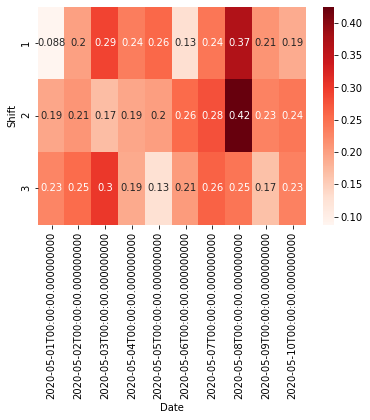

In [25]:
sns.heatmap(df111, cmap="Reds", annot=True)

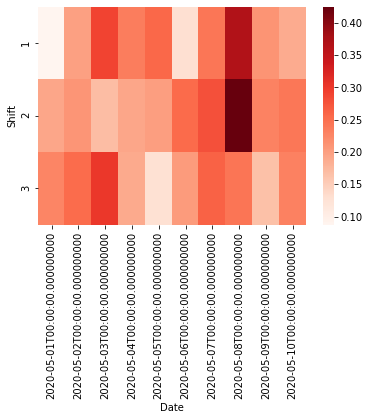

NameError: name 'months' is not defined

AttributeError: 'DataFrame' object has no attribute 'ix'

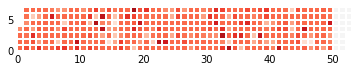